In [6]:
import idx2numpy
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import pandas as pd

t10k = idx2numpy.convert_from_file('../data/t10k-images-idx3-ubyte')

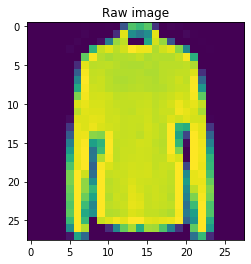

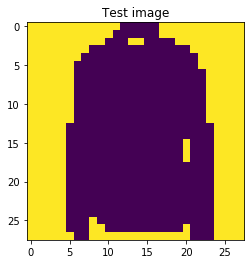

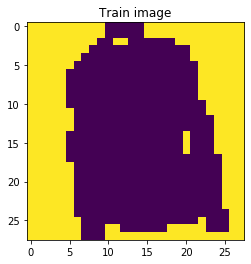

In [53]:
# shows how I transfrom images

def binary(im):
    x = torch.zeros(1,28,28)
    y = torch.ones(1,28,28)
    return torch.where(im > 0.1, x, y)

# define transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=(-8, 8)),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])
    
x = t10k[7030]
    
# raw image
plt.figure()
plt.title("Raw image")
plt.imshow(Image.fromarray(np.uint8(x)))
    
# test image
im = transform_test(Image.fromarray(np.uint8(x)))
im = binary(im)
plt.figure()
plt.title("Test image")
plt.imshow(transforms.ToPILImage()(im))
    
# train image
im = transform_train(Image.fromarray(np.uint8(x)))
im = binary(im)
plt.figure()
plt.title("Train image")
plt.imshow(transforms.ToPILImage()(im))

In [55]:
# Show labels
labels = idx2numpy.convert_from_file('../data/train-labels-idx1-ubyte')
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

In [50]:
# shows how to prepare test_loader

def prepare_test_data(t10k):
    # define transform
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # transform test datasets
    new_test = []
    for x in t10k:
        im = transform_test(Image.fromarray(np.uint8(x)))
        im = binary(im)
        new_test.append(im)
    
    # convert to tensor of proper size
    test_tensor = torch.Tensor(len(new_test), 28, 28)
    torch.cat(new_test, out=test_tensor)
    new_test = test_tensor.view(-1, 1, 28, 28)
    
    # create dataset
    test_data = TensorDataset(new_test)

    # create data loader
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=1
    )
    return test_loader

test_loader = prepare_test_data(t10k)

In [14]:
# create model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7 * 7 * 16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
    
model = Net()
model.load_state_dict(torch.load('../trained_model.pt'))

<All keys matched successfully>

In [39]:
model.eval()

output = []

for batch_idx, (data,) in enumerate(test_loader):
    output.append([batch_idx, torch.argmax(model(data)).item()])

In [48]:
Submission = pd.DataFrame(output, columns=['Id','Class'])
Submission.to_csv('kaggle.out.csv', index=False)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])